In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
from collections import OrderedDict
from tqdm import tqdm

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [5]:
lgb.__version__

'3.3.2'

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 1
DATASET_VERSION = "05"

In [4]:
OUT_PATH = Path(f"../data/pfi/")

if not OUT_PATH.exists():
    OUT_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [6]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 8135 entries, P_2_mean_nan to S_2_max_gap
dtypes: float32(5473), int16(49), int8(2613)
memory usage: 10.5+ GB


In [8]:
input_feats = train.columns.tolist()
#categ_feats = [
#    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
#    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
#    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
#    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
#]
len(input_feats)

8135

In [9]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

0

***
## model training

In [10]:
model_params = {
    'boosting':'gbdt',
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [11]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    oof_dfs = list()
    
    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            #categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            #categorical_feature=categ_feats,
            free_raw_data=True,
        )
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=3000,
            callbacks=[
                lgb.log_evaluation(period=50), 
                lgb.early_stopping(300, first_metric_only=True)
            ],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        valid_df.loc[:,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        oof_dfs.append(valid_df)
        del train_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof_dfs

############################### repeated cross-validation step: 1/1 ################################
######################################## training model 1/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.76674	valid_0's recall_at4: 0.624674	valid_0's norm_gini: 0.908806
[100]	valid_0's amex_metric: 0.778554	valid_0's recall_at4: 0.641084	valid_0's norm_gini: 0.916024
[150]	valid_0's amex_metric: 0.786685	valid_0's recall_at4: 0.653707	valid_0's norm_gini: 0.919662
[200]	valid_0's amex_metric: 0.789556	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.921577
[250]	valid_0's amex_metric: 0.791677	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922579
[300]	valid_0's amex_metric: 0.792845	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923231
[350]	valid_0's amex_metric: 0.793278	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.923719
[400]	valid_0's amex_metric: 0.793663	valid_0

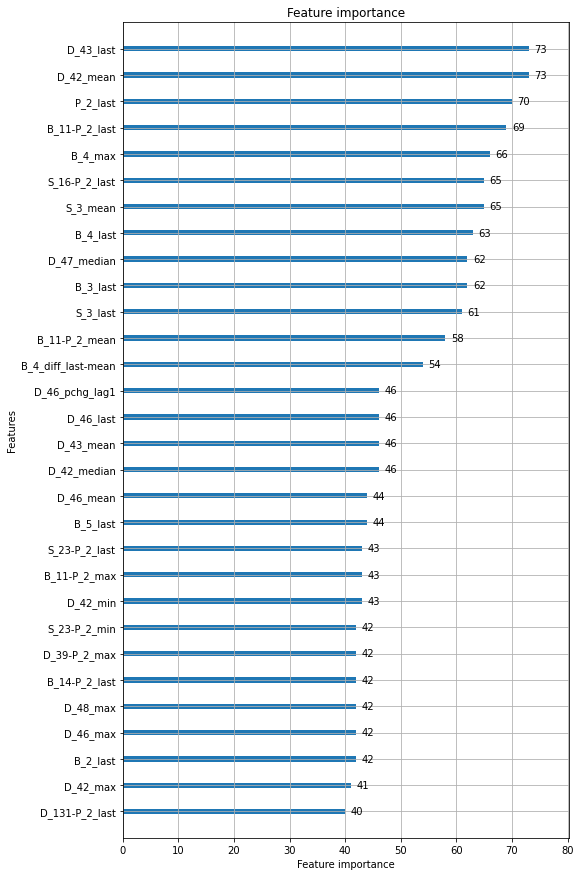

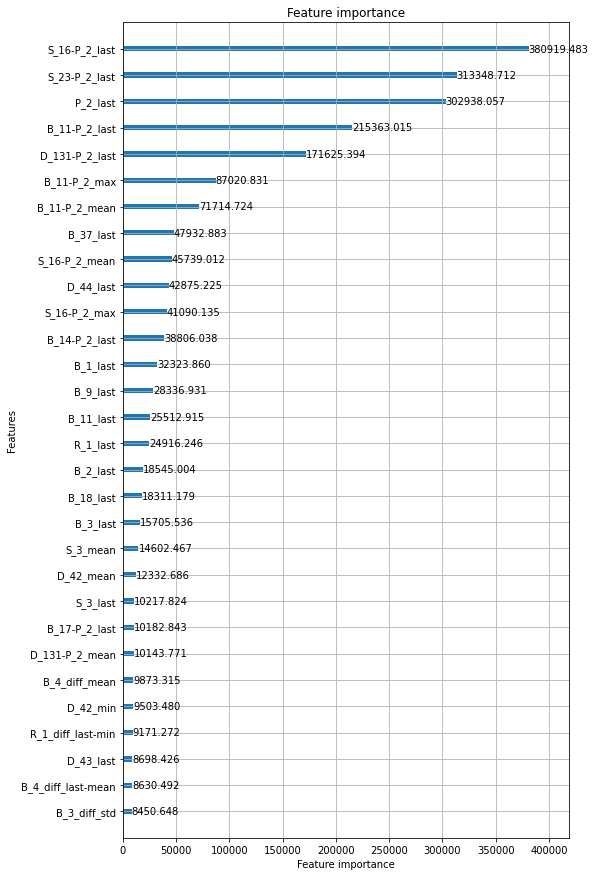

######################################## training model 2/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.765096	valid_0's recall_at4: 0.622276	valid_0's norm_gini: 0.907917
[100]	valid_0's amex_metric: 0.776944	valid_0's recall_at4: 0.638896	valid_0's norm_gini: 0.914992
[150]	valid_0's amex_metric: 0.785226	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.918597
[200]	valid_0's amex_metric: 0.789439	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.920626
[250]	valid_0's amex_metric: 0.791813	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.921798
[300]	valid_0's amex_metric: 0.792279	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.922562
[350]	valid_0's amex_metric: 0.793229	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.923115
[400]	valid_0's amex_metric: 0.793564	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.92349
[450]	valid_0's amex_metric: 0.794209	valid_0's

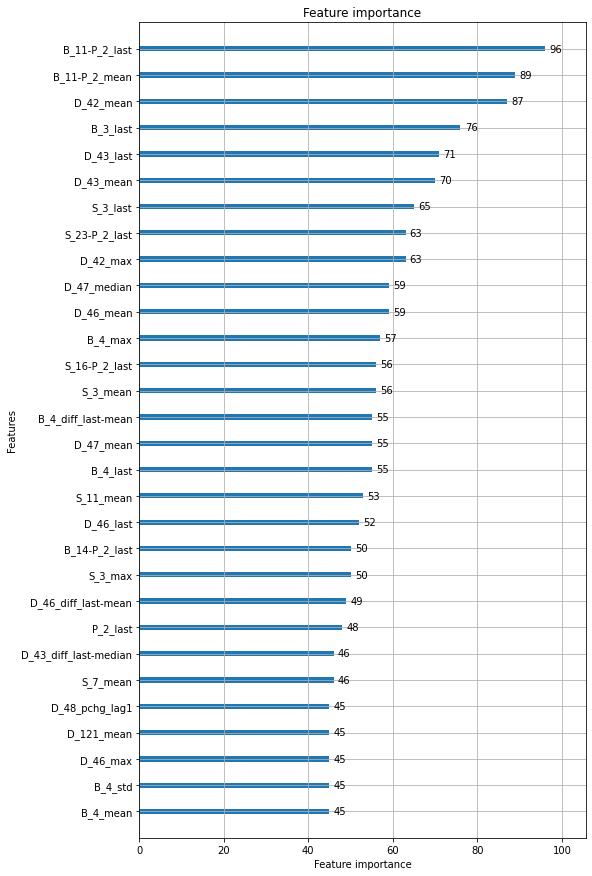

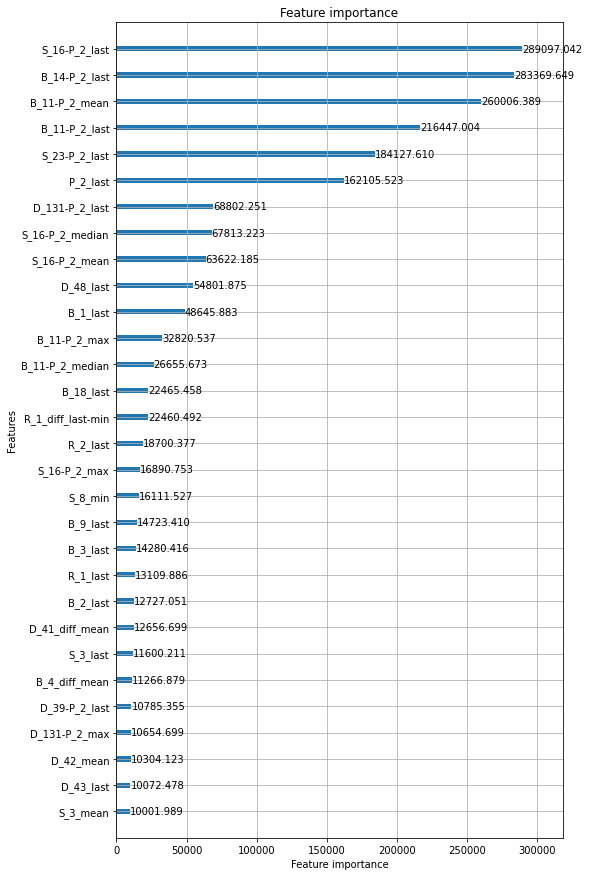

######################################## training model 3/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.7609	valid_0's recall_at4: 0.61487	valid_0's norm_gini: 0.90693
[100]	valid_0's amex_metric: 0.772465	valid_0's recall_at4: 0.631028	valid_0's norm_gini: 0.913903
[150]	valid_0's amex_metric: 0.77928	valid_0's recall_at4: 0.641168	valid_0's norm_gini: 0.917393
[200]	valid_0's amex_metric: 0.783118	valid_0's recall_at4: 0.646975	valid_0's norm_gini: 0.919261
[250]	valid_0's amex_metric: 0.784205	valid_0's recall_at4: 0.648111	valid_0's norm_gini: 0.920299
[300]	valid_0's amex_metric: 0.785424	valid_0's recall_at4: 0.649794	valid_0's norm_gini: 0.921053
[350]	valid_0's amex_metric: 0.786691	valid_0's recall_at4: 0.651814	valid_0's norm_gini: 0.921568
[400]	valid_0's amex_metric: 0.787012	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.921916
[450]	valid_0's amex_metric: 0.787922	valid_0's rec

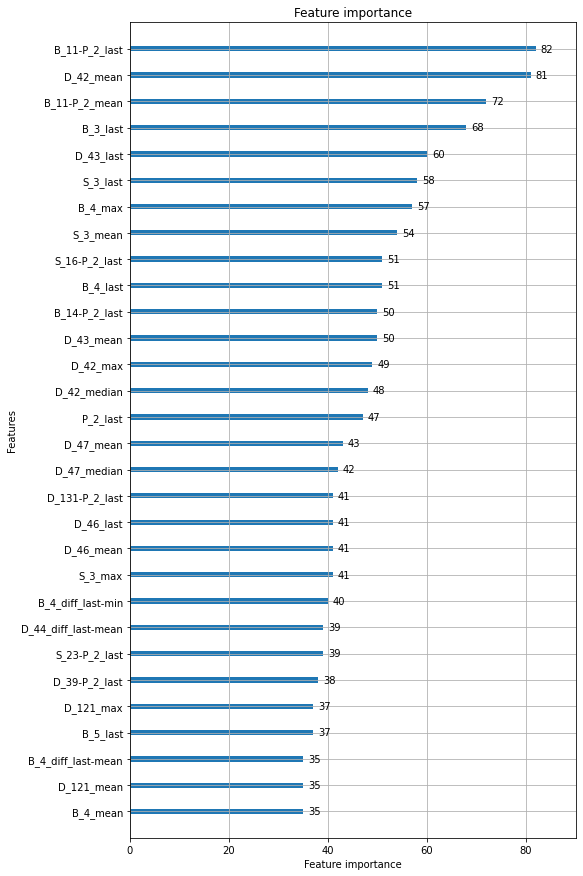

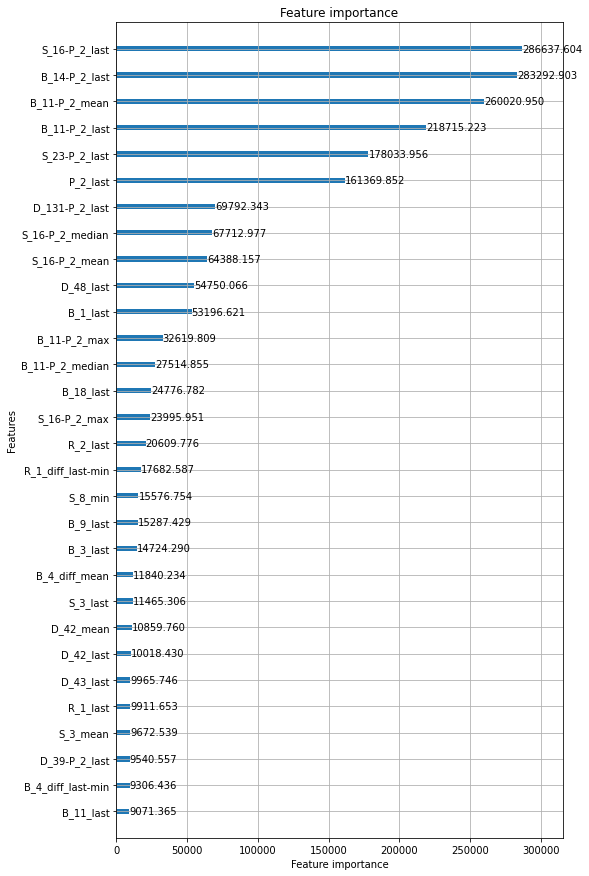

######################################## training model 4/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.76033	valid_0's recall_at4: 0.614054	valid_0's norm_gini: 0.906605
[100]	valid_0's amex_metric: 0.774244	valid_0's recall_at4: 0.634841	valid_0's norm_gini: 0.913648
[150]	valid_0's amex_metric: 0.779425	valid_0's recall_at4: 0.641616	valid_0's norm_gini: 0.917234
[200]	valid_0's amex_metric: 0.782065	valid_0's recall_at4: 0.64494	valid_0's norm_gini: 0.91919
[250]	valid_0's amex_metric: 0.783867	valid_0's recall_at4: 0.647296	valid_0's norm_gini: 0.920438
[300]	valid_0's amex_metric: 0.785715	valid_0's recall_at4: 0.6502	valid_0's norm_gini: 0.92123
[350]	valid_0's amex_metric: 0.785827	valid_0's recall_at4: 0.649863	valid_0's norm_gini: 0.921792
[400]	valid_0's amex_metric: 0.787386	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.922215
[450]	valid_0's amex_metric: 0.787926	valid_0's reca

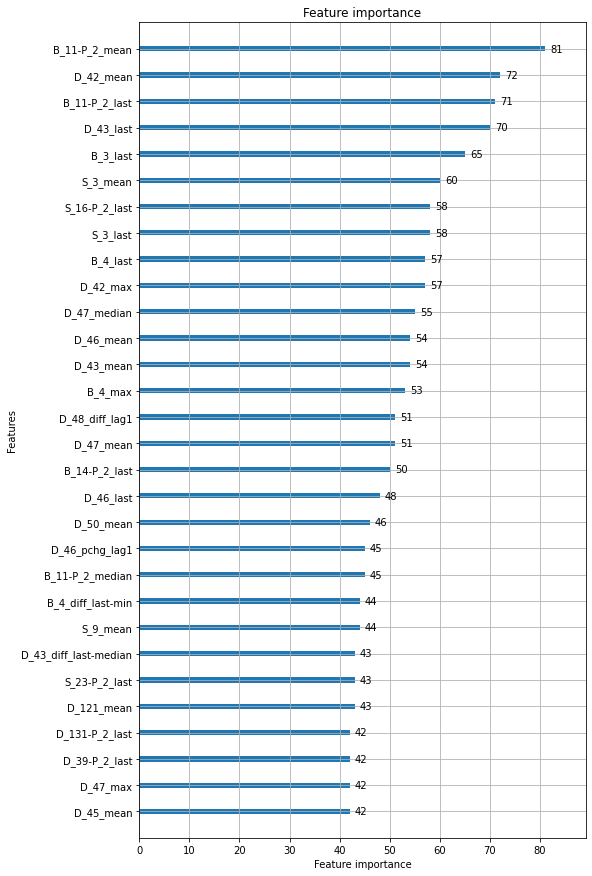

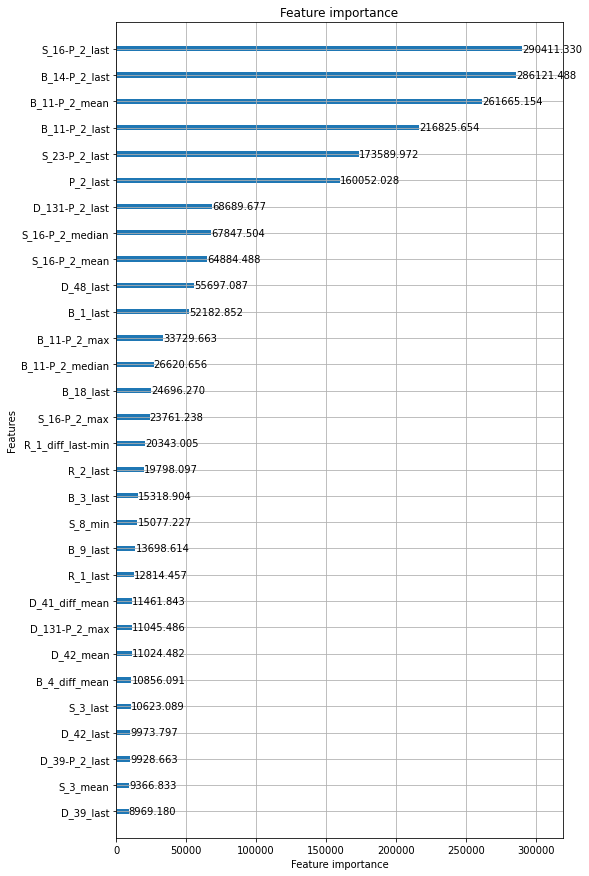

######################################## training model 5/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.76979	valid_0's recall_at4: 0.629665	valid_0's norm_gini: 0.909915
[100]	valid_0's amex_metric: 0.780958	valid_0's recall_at4: 0.644772	valid_0's norm_gini: 0.917145
[150]	valid_0's amex_metric: 0.788427	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.920721
[200]	valid_0's amex_metric: 0.791316	valid_0's recall_at4: 0.660046	valid_0's norm_gini: 0.922586
[250]	valid_0's amex_metric: 0.792819	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.923781
[300]	valid_0's amex_metric: 0.794408	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924478
[350]	valid_0's amex_metric: 0.796119	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.924954
[400]	valid_0's amex_metric: 0.796821	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.925347
[450]	valid_0's amex_metric: 0.797297	valid_0's

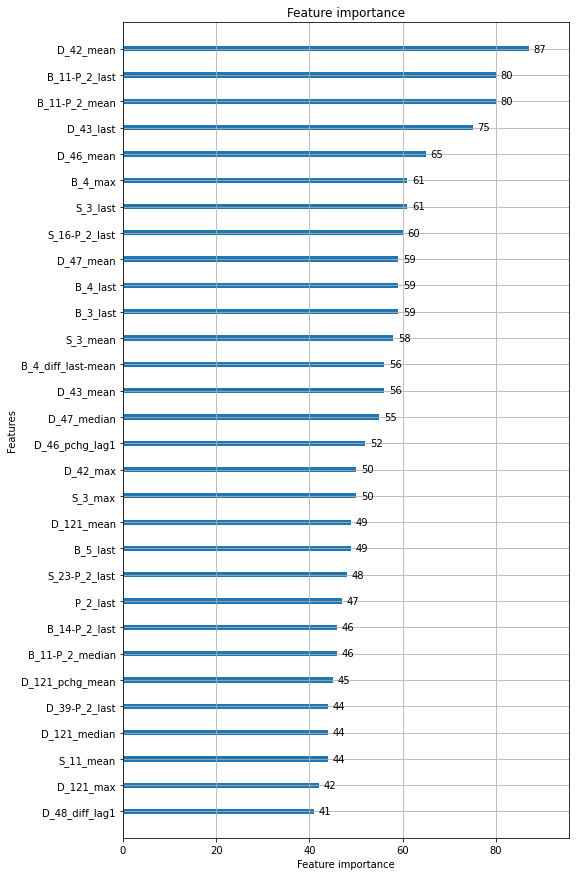

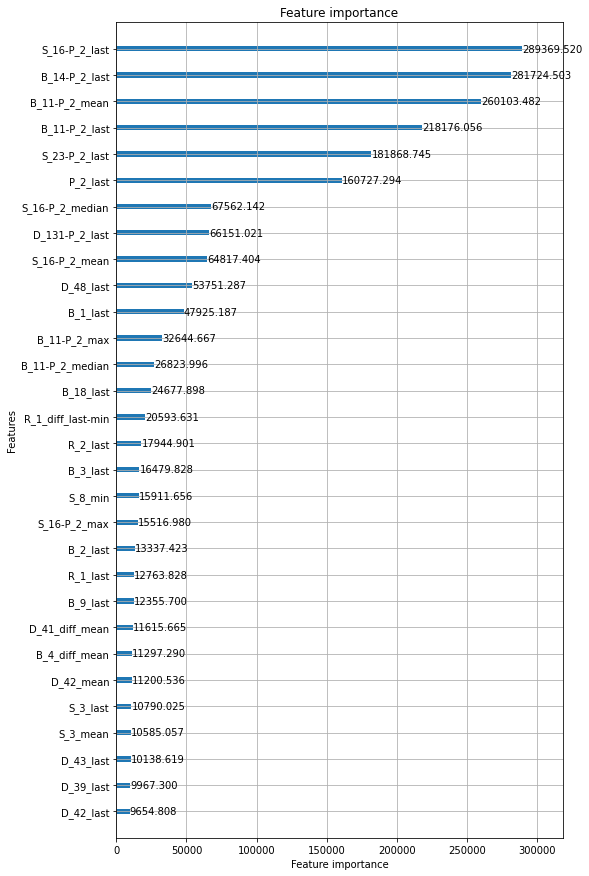

Training time: 63.0650204261144 min.
CPU times: user 12h 9min 16s, sys: 1min 57s, total: 12h 11min 13s
Wall time: 1h 3min 23s


In [12]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof_dfs = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
              
    all_models.extend(models)
    all_oof_dfs.extend(oof_dfs)
              
    del _train, folds; gc.collect()

***
## computes PFI

In [13]:
def compute_pfi(
        model:lgb.Booster,
        dataframe:pd.DataFrame, 
        features:list, 
        target:str
    ):
    
    # calculates base score
    preds = model.predict(dataframe[features])
    target = dataframe[target].values
    BASE_SCORE = compute_amex_metric(target, preds)

    output = OrderedDict()
    output["base_score"] = BASE_SCORE

    # calculates pfi for each feature
    for col in tqdm(features):
        _dataframe = dataframe.copy()
        index = np.random.permutation(_dataframe.index.values)
        _dataframe[col] = _dataframe.loc[index,col].values
        preds = model.predict(_dataframe[features])
        score = compute_amex_metric(target, preds)
        pfi = (BASE_SCORE - score)
        output[col] = pfi
        
        del _dataframe; gc.collect()
    
    return output

In [14]:
for model,oof_df in zip(all_models,all_oof_dfs):
    break

In [ ]:
%%timeit -n 10 
model.predict(oof_df[input_feats])

In [ ]:
import daal4py as d4p
import lleaves

***
### testing daal4py

In [58]:
daal_model = d4p.get_gbt_model_from_lightgbm(model)
daal_model

NotImplementedError: Categorical features are not supported in daal4py Gradient Boosting Trees

In [67]:
model.save_model("tmp-lgbm.txt")
llvm_model = lleaves.Model("tmp-lgbm.txt")
llvm_model.compile()

In [70]:
%%timeit
llvm_model.predict(oof_df[input_feats])

1.93 s ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%time
output = compute_pfi(
    model=model,
    dataframe=oof_df,
    features=input_feats,
    target="target",
)

  1% 100/8135 [28:00<37:30:43, 16.81s/it]


KeyboardInterrupt: 

In [16]:
output_df = pd.DataFrame([output,])
output_df

NameError: name 'output' is not defined

In [54]:
output_df.iloc[0,1:].sort_values(ascending=False).head(50)

B_11-P_2_last        0.007333
B_14-P_2_last        0.003541
B_3_last             0.002507
S_16-P_2_last        0.002314
B_37_last            0.002096
S_23-P_2_mean        0.001850
D_43_last            0.001740
B_5_last             0.001585
B_14-P_2_mean        0.001535
D_131-P_2_max        0.001524
D_47_mean            0.001497
S_3_mean             0.001477
D_44_diff_wmean      0.001413
R_1_last             0.001412
B_9_last             0.001369
D_50_max             0.001331
B_7_last             0.001284
R_3_last             0.001258
S_3_last             0.001243
D_66_last            0.001211
B_8_mean             0.001203
D_131-P_2_last       0.001202
D_123_diff_wfirst    0.001191
D_43_mean            0.001181
B_11_last            0.001162
P_2_last             0.001144
S_26_mean            0.001140
B_25_diff            0.001120
D_46_diff            0.001115
B_3_diff_wmean       0.001112
B_4_diff             0.001103
S_23-P_2_last        0.001084
B_3_max              0.001035
D_51_mean 